In [282]:
from comet2 import Comet
from approximations import Approx as app
from asteroids import Asteroids
import numpy as np
from numba import jit
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from collections import defaultdict
from sklearn.linear_model import LinearRegression
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error
from decimal import Decimal


In [283]:
dt = 0.001

@jit(forceobj = True)
def sim(V_init: int, M_init: float, angle: int = 45) -> tuple[np.ndarray, np.ndarray, np.ndarray, bool, int]:
    """
    Simulates the trajectory of a meteor given:
    The initial velocity, initial mass and angle of entry

    Returns multiple lists containing the mass, velocity and distance over time.
    """

    comet = Comet(V_init, M_init, angle)

    masses = np.zeros(900000)
    velocities = np.zeros(900000)
    heights = np.zeros(900000)
    widths = np.zeros(900000)
    t: int = 0
    while comet.m > 0 and comet.v > 0 and comet.h > 0 and t/dt < 900000:
        
        app.euler(dt, comet)
        app.velocity_verlet(dt, comet)

        masses[int(t/dt)] = comet.m
        velocities[int(t/dt)] = comet.v
        heights[int(t/dt)] = comet.h
        widths[int(t/dt)] = comet.w

        t += dt
    
    if comet.h <= 0:
        hit = True
    else: 
        hit = False

    return masses, velocities, heights, widths, hit, t

Validation of the simulation

In [284]:
# Intial velocities and corresponding masses from Mehta et al. (2018) article to validate simulation
init_velo = [10000, 14000, 18000, 22000, 26000, 30000, 34000, 38000]
init_mass = [0.05, 0.1, 0.2, 0.72, 2.64, 13.5, 132, 13000]

# For each velocity and mass, the error between the estimations from Mehta et al. and the simulation is calculated
Y_pred: list[float] = []

for i in range(len(init_velo)):
    masses, velocities, distances, widths, hit, t = sim(init_velo[i], init_mass[i])
    Y_pred.append(masses[int(t/dt) - 1])


In [285]:
Y_true = [0.02 for i in range(len(init_velo))]
MSE = mean_squared_error(Y_true, Y_pred)
print("MSE: ", MSE)

MSE:  0.00029407623137512706


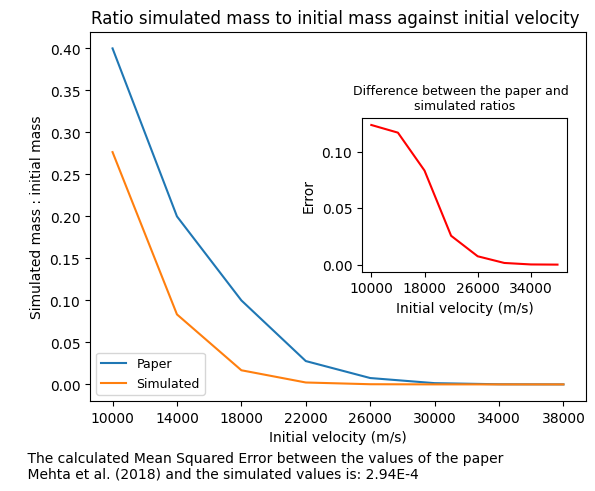

In [286]:
true_error = [(Y_true[i]) / init_mass[i] for i in range(len(init_mass))]
pred_error = [(Y_pred[i]) / init_mass[i] for i in range(len(init_mass))]

diff = [abs(pred_error[i] - true_error[i]) for i in range(len(init_mass))]

fig, ax1 = plt.subplots()

left, bottom, width, height = [0.55, 0.38, 0.32, 0.32]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(true_error, label='Paper')
ax1.plot(pred_error, label='Simulated')
ax1.set_xticks(ticks=list(range(8)), labels = init_velo)
ax1.set_xlabel('Initial velocity (m/s)')
ax1.set_ylabel('Simulated mass : initial mass')
ax1.set_title('Ratio simulated mass to initial mass against initial velocity ')
ax1.legend(loc='lower left', fontsize=9)

ax2.plot(diff, c='red')
ax2.set_xticks(ticks=[2*i for i in range(4)], labels=[init_velo[2*i] for i in range(4)])
ax2.set_xlabel('Initial velocity (m/s)')
ax2.set_ylabel('Error')
ax2.set_title('Difference between the paper and  \nsimulated ratios', size=9)

plt.figtext(0.0, -0.05 , f"    The calculated Mean Squared Error between the values of the paper \n\
    Mehta et al. (2018) and the simulated values is: {Decimal(MSE):.2E}")
plt.show()

The experiment

For each of the given velocities and masses from the NASA dataset, the simulation will be run using different angels of impact. 
The results will be saved in a file.

In [287]:
filename = 'nasa_dataset\\impacts.csv'

asteroids = Asteroids(filename)
V_inits = asteroids.velocity()
M_inits = asteroids.mass()

In [288]:
n = 30
results = defaultdict(dict)

for i in range(n):
    angle = np.random.rand() * 80
    masses, velocities, heights, widths, hit, t = sim(V_inits[i], M_inits[i], angle)
    results[i]['finals'] = (masses[int(t/dt)-1], velocities[int(t/dt)-1], heights[int(t/dt)-1])
    results[i]['angle'] = angle
    results[i]['height'] = heights[heights != 0]
    results[i]['mass'] = masses[masses != 0]
    results[i]['velocity'] = velocities[velocities != 0]
    results[i]['hit'] = hit

In [289]:
columns = ['M_init', 'V_init', 'm_fin', 'h_fin', 'angle']
df = pd.DataFrame([[M_inits[i], V_inits[i], results[i]['finals'][0], results[i]['finals'][2], results[i]['angle']] for i in range(n)], columns=columns)

In [290]:
df.head()

,M_init,V_init,m_fin,h_fin,angle
0,6.285803e+05,17770.0,1.238793e+04,2404.415466,77.063136
1,1.466077e+04,8980.0,5.054233e+03,-0.138037,38.028606
2,1.466077e+04,18330.0,2.252341e+02,1308.990996,8.359886
3,7.506312e+06,4990.0,6.178418e+06,-0.133602,73.355679
4,2.249758e+11,19460.0,2.084056e+11,-3.425506,12.290617


In [291]:
reg = LinearRegression()

X = df.drop(['m_fin', 'h_fin'], axis=1)
Y = df['m_fin']

reg.fit(X, Y)
print(reg.score(X, Y))
print(reg.coef_)


0.9995309160934424
[ 9.54721516e-01 -5.61474870e+04  3.34227106e+06]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


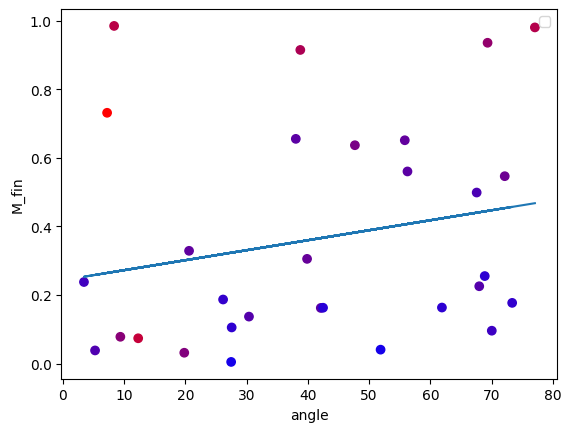

In [292]:

max_Vinit = max([results[i]['velocity'][0] for i in range(n)])
c_c = [[results[i]['velocity'][0] / max_Vinit, 0.0, (max_Vinit - results[i]['velocity'][0]) / max_Vinit] for i in range(n)]

x_var = df['angle']
y_var = [(df['M_init'][i] - df['m_fin'][i]) / df['M_init'][i] for i in range(len(df['m_fin']))]
plt.scatter(x_var, y_var, c = c_c)

#calculate equation for trendline
z = np.polyfit(x_var, y_var, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x_var, p(x_var))

plt.xlabel('angle')
plt.ylabel('M_fin')

plt.legend()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'M_fin')

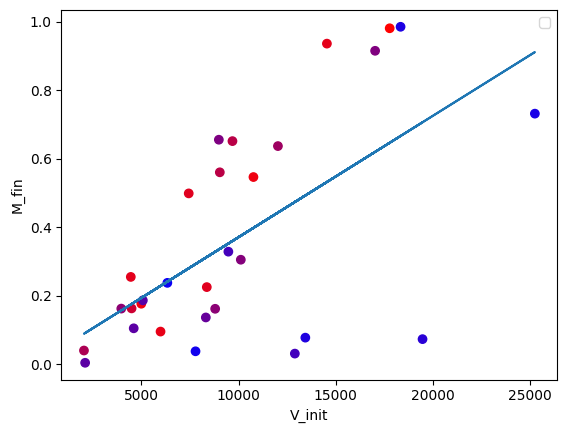

In [293]:
max_angle = max(df['angle'])
c_c = [[df['angle'][i] / max_angle, 0.0, (max_angle - df['angle'][i]) / max_angle] for i in range(n)]

x_var = df['V_init']
y_var = [(df['M_init'][i] - df['m_fin'][i]) / df['M_init'][i] for i in range(len(df['m_fin']))]
plt.scatter(x_var, y_var, c=c_c)

#calculate equation for trendline
z = np.polyfit(x_var, y_var, 1)
p = np.poly1d(z)

#add trendline to plot
plt.plot(x_var, p(x_var))

plt.legend()
plt.xlabel('V_init')
plt.ylabel('M_fin')

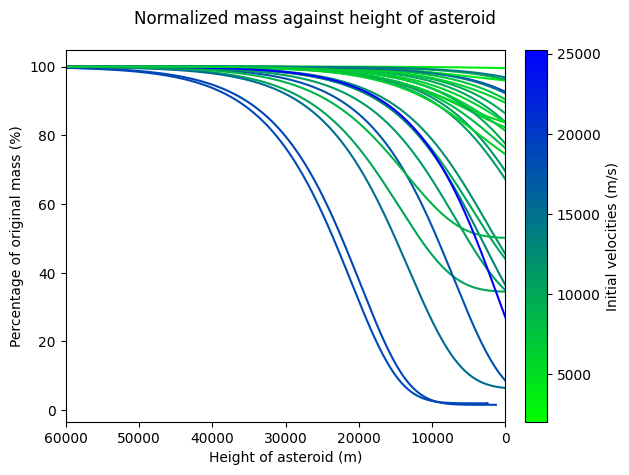

In [309]:
max_Vinit = max([results[i]['velocity'][0] for i in range(n)])


c_c = [[0.0, (max_Vinit - results[i]['velocity'][0]) / max_Vinit, results[i]['velocity'][0] / max_Vinit] for i in range(n)]

fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[20, 1])

for i in range(n):
    norm_mass = [mass / results[i]['mass'][0] * 100 for mass in results[i]['mass']]  
    ax1.plot(results[i]['height'], norm_mass, c=c_c[i])
    ax1.set_xlim(60000, 0)


colors = ["#00FF00", "#0000FF"]
values = [int(min(V_inits[:n])), int(max(V_inits[:n]))]

norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values))
normed_vals = norm(values)

cmap = LinearSegmentedColormap.from_list("mypalette", list(zip(normed_vals, colors)), N=1000)
cb = mpl.colorbar.ColorbarBase(ax=ax2, cmap=cmap, norm=norm, orientation='vertical')

ax1.set_xlabel('Height of asteroid (m)')
ax1.set_ylabel('Percentage of original mass (%)')
ax2.set_ylabel('Initial velocities (m/s)')
plt.suptitle('Normalized mass against height of asteroid')
fig.tight_layout()

plt.show()



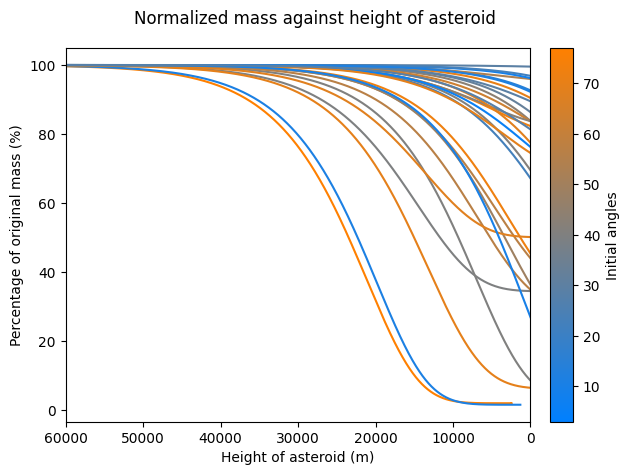

In [312]:
angles = [results[i]['angle'] for i in range(n)]
max_angle = max(angles)

c_ca = [[results[i]['angle'] / max_angle, 0.5, (max_angle - results[i]['angle']) / max_angle] for i in range(n)]

fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[20, 1])

for i in range(n):
    norm_mass = [velo / results[i]['mass'][0] * 100 for velo in results[i]['mass']]  
    ax1.plot(results[i]['height'], norm_mass, c=c_ca[i])


ax1.set_xlim(60000, 0)

colors = ["#0080FF", "#FF8000"]
values = [int(min(angles)), int(max(angles))]

norm = mpl.colors.Normalize(vmin=min(values), vmax=max(values))
normed_vals = norm(values)

cmap = LinearSegmentedColormap.from_list("mypalette", list(zip(normed_vals, colors)), N=1000)
cb = mpl.colorbar.ColorbarBase(ax=ax2, cmap=cmap, norm=norm, orientation='vertical')

ax1.set_xlabel('Height of asteroid (m)')
ax1.set_ylabel('Percentage of original mass (%)')
ax2.set_ylabel('Initial angles')
plt.suptitle('Normalized mass against height of asteroid')
fig.tight_layout()

plt.show()

Sensitivity analysis

In [296]:
import itertools
anvelinmass = [[5000, 10000],[1000],[20, 45, 70]]

sens_res = defaultdict(dict)
i = 0
for element in itertools.product(*anvelinmass):
    masses, velocities, heights, widths, hit, t  = sim(element[0], element[1], element[2])
    sens_res[i]['angle'] = element[2]
    sens_res[i]['height'] = heights[masses != 0]
    sens_res[i]['mass'] = masses[masses != 0]
    sens_res[i]['velocity'] = velocities[masses != 0]
    i += 1
    print(element)
    

(5000, 1000, 20)
(5000, 1000, 45)
(5000, 1000, 70)
(10000, 1000, 20)
(10000, 1000, 45)
(10000, 1000, 70)


In [297]:
print(sens_res)

defaultdict(<class 'dict'>, {0: {'angle': 20, 'height': array([ 1.99995302e+05,  1.99990603e+05,  1.99985905e+05, ...,
        1.35249709e-01,  6.08688924e-02, -1.35112331e-02]), 'mass': array([1000.        , 1000.        , 1000.        , ...,  716.28696088,
        716.28695416,  716.28694745]), 'velocity': array([5000.00400329, 5000.00800657, 5000.01200986, ...,   79.15477941,
         79.15404393,   79.15330849])}, 1: {'angle': 45, 'height': array([ 1.99996464e+05,  1.99992929e+05,  1.99989393e+05, ...,
        1.00156691e-01,  3.96748123e-02, -2.08067774e-02]), 'mass': array([1000.        , 1000.        , 1000.        , ...,  705.52707223,
        705.52706384,  705.52705545]), 'velocity': array([5000.00515341, 5000.01030682, 5000.01546023, ...,   85.53449651,
         85.53408849,   85.53368048])}, 2: {'angle': 70, 'height': array([ 1.99998290e+05,  1.99996580e+05,  1.99994870e+05, ...,
        5.21852962e-02,  2.10303129e-02, -1.01245986e-02]), 'mass': array([1000.        , 1000.

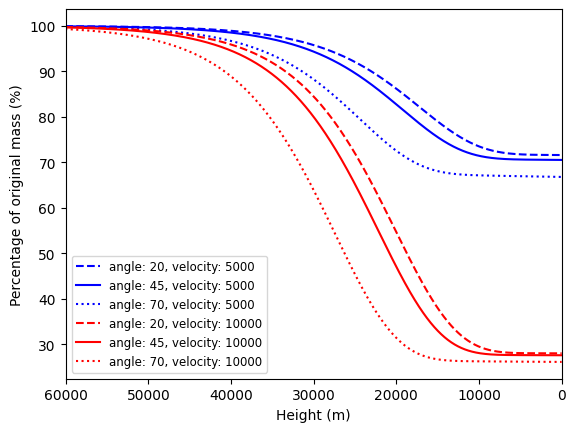

In [298]:
for i in range(6):
    norm_mass = [mass / sens_res[i]['mass'][0] * 100 for mass in sens_res[i]['mass']]
    
    if sens_res[i]['velocity'][0] > 9000: 
        color = 'r'
        if sens_res[i]['angle'] == 45: linestyle, label = 'solid', 'angle: 45, velocity: 10000'
        elif sens_res[i]['angle'] == 20: linestyle, label = 'dashed', 'angle: 20, velocity: 10000'
        else: linestyle, label = 'dotted', 'angle: 70, velocity: 10000'
    else: 
        color = 'b'
        if sens_res[i]['angle'] == 45: linestyle, label = 'solid', 'angle: 45, velocity: 5000'
        elif sens_res[i]['angle'] == 20: linestyle, label = 'dashed', 'angle: 20, velocity: 5000'
        else: linestyle, label = 'dotted', 'angle: 70, velocity: 5000'

    plt.plot(sens_res[i]['height'], norm_mass, c = color, linestyle = linestyle, label = label)
    plt.xlim(60000, 0)

plt.legend(fontsize = 8.5)
plt.xlabel('Height (m)')
plt.ylabel('Percentage of original mass (%)')
plt.show()